# Credible set size quality controls

The goal of the analusis is to check the distribution of the credible set sizes

- across the major ancestry groups
- across study types


## Data Loading

The data required for this analysis is loaded from the `computed maf` dataset.t


In [9]:
from gentropy.common.session import Session
from pyspark.sql import functions as f

from manuscript_methods.datasets import LeadVariantEffect


In [10]:
session = Session(extended_spark_conf={"spark.driver.memory": "40G"})
lead_maf_dataset_path = "../../data/lead-maf-vep"


In [11]:
session.spark


In [12]:
dataset_maf = LeadVariantEffect.from_parquet(session, lead_maf_dataset_path)
dataset = dataset_maf.df.select(
    "studyLocusId",
    "variantId",
    "credibleSetSize",
    "studyStatistics.studyType",
).toPandas()


In [13]:
dataset.describe()


,credibleSetSize
count,2.833758e+06
mean,2.463540e+01
std,8.711132e+01
min,1.000000e+00
25%,2.000000e+00
50%,8.000000e+00
75%,2.500000e+01
max,1.024800e+04


## Plot the distribution of credible set sizes

The credible set size is computed based on the number of unique variants in the **studyLocus.locus object**.

<img src="plots/01.3_credible_set_size_overall.jpg" width="300">


/Users/ss60/Projects/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5.35 x 4.5 in image.
/Users/ss60/Projects/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/01.3_credible_set_size_overall.jpg


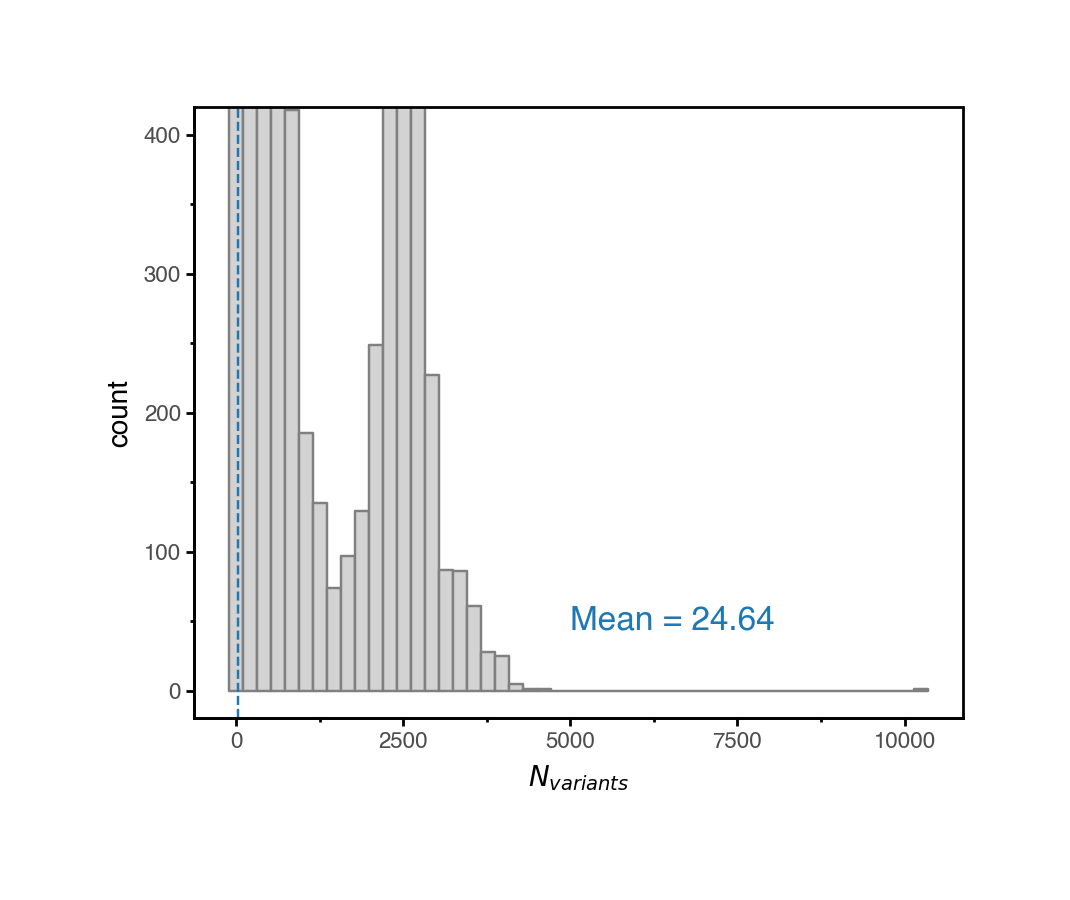

In [20]:
from plotnine import (
    aes,
    annotate,
    coord_cartesian,
    element_blank,
    element_line,
    element_rect,
    element_text,
    geom_histogram,
    geom_vline,
    ggplot,
    labs,
    theme,
)

REM = 10
mean_val = dataset["credibleSetSize"].mean()
median_val = dataset["credibleSetSize"].median()
xmax = dataset["credibleSetSize"].max()
xmin = dataset["credibleSetSize"].min()
ymax = 100

p = (
    ggplot(data=dataset, mapping=aes(x="credibleSetSize"))
    + geom_histogram(
        bins=50,
        color="grey",
        fill="lightgray",
    )
    + coord_cartesian(ylim=(0, 400))  # limit y-axis to hide the spike
    + labs(x=r"$N_{variants}$")
    + geom_vline(xintercept=mean_val, color="#1f77b4", linetype="dashed", size=0.5, show_legend=True)
    + theme(
        # figure_size=(REM, REM*0.75),
        figure_size=(5.35, 4.5),  # ~85mm wide
        axis_title=element_text(size=REM * 1, family="sans-serif"),
        axis_text=element_text(size=REM * 0.8, family="sans-serif"),
        axis_ticks=element_line(color="black"),
        axis_line=element_line(color="black"),
        panel_background=element_rect(fill="white"),
        panel_border=element_rect(color="black", fill=None),
        panel_grid=element_blank(),
        # plot_margin=0.25,
        plot_margin=0.1,
    )
    + annotate(
        "text",
        x=5000,
        y=50,
        label=f"Mean = {mean_val:.2f}",
        ha="left",
        size=12,
        color="#1f77b4",
        fontweight="bold",
    )
)


p.save("plots/01.3_credible_set_size_overall.jpg", dpi=300, bbox_inches="tight")
p


## Distribution of credible set study types

The study types were derived from the `studyIndex.studyType` column and enhanced by the `studyLocus.isTransQtl` column.


In [14]:
from manuscript_methods import group_statistics

grouped_data = (
    group_statistics(
        dataset_maf.df.select(
            "studyLocusId",
            "variantId",
            "credibleSetSize",
            "studyStatistics.studyType",
        ),
        f.col("studyType"),
    )
    .orderBy(f.desc("count"))
    .toPandas()
)
grouped_data


,studyType,count,%
0,eqtl,1349478,47.62
1,gwas,789453,27.86
2,tuqtl,384852,13.58
3,sqtl,223500,7.89
4,sceqtl,52744,1.86
5,pqtl,33731,1.19


In [15]:
# Plot the grouped data
from plotnine import geom_bar, scale_color_brewer

p_grouped = (
    ggplot(data=grouped_data, mapping=aes(x="studyType", y="count"))
    + geom_bar(aes(fill="studyType"), stat="identity", position="dodge")
    + scale_color_brewer(type="qual", palette="Set1")
    # + labs(x="Study Type", y="Percentage of Credible Sets")
    # + theme(
    #     figure_size=(5.35, 4.5),  # ~85mm wide
    #     axis_title=element_text(size=REM * 1, family="sans-serif"),
    #     axis_text=element_text(size=REM * 0.8, family="sans-serif"),
    #     axis_ticks=element_line(color="black"),
    #     axis_line=element_line(color="black"),
    #     panel_background=element_rect(fill="white"),
    #     panel_border=element_rect(color="black", fill=None),
    #     panel_grid=element_blank(),
    #     plot_margin=0.1,
    #     legend_position="top",
    #     legend_title=element_blank(),
    #     legend_text=element_text(size=REM * 0.8, family="sans-serif"),
    #     legend_key_size=REM * 0.8,
    #     legend_box_spacing=REM * 0.2,
    # )
)
p_grouped


NameError: name 'ggplot' is not defined

## Plot the distribution of credible set sizes across the study types
